In [83]:
# make dataframe from excell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# loop through all files in folder
def getDataframe(path):
    merged = pd.DataFrame()
    for r, d, f in os.walk(path):
        for file in f:
            if '.xls' in file:
                merged = pd.concat([merged, pd.read_excel(os.path.join(r, file))], ignore_index=True)
    # merged.reindex(sorted(merged.columns), axis=1)
    return merged

df = getDataframe('./records')
columns = df.columns

In [84]:
def getDiff(pagesCol =  ['End Page', 'Start Page']):
    baseStats = df[pagesCol].copy()
    baseStats.dropna(inplace=True)
    baseStats.replace('+', regex=True, inplace=True)

    sum = 0
    count = 0
    baseStats.head()
    for i in baseStats.index:
        if type(baseStats.at[i, 'End Page']) == int and type(baseStats.at[i, 'Start Page']) == int:
            sum += (baseStats.at[i, 'End Page'] - baseStats.at[i, 'Start Page'])
            count += 1
    return sum / count

print("Avg Page Num:", getDiff())
print("Avg Cited Reference Count:", df['Cited Reference Count'].mean())


def getCats():
    baseStats = df[['WoS Categories']].copy()
    emptyStuff = []
    for i in baseStats.index:
        if type(baseStats.at[i, 'WoS Categories']) == str:
            for j in baseStats.at[i, 'WoS Categories'].split(';'):
                emptyStuff.append(j.strip())
    dfToWork = pd.DataFrame(emptyStuff, columns=['category'])
    print(len(emptyStuff))
    print(dfToWork.groupby('category')['category'].agg('count').sort_values(ascending=False))
getCats()

Avg Page Num: 14.95368782161235
Avg Cited Reference Count: 42.079
1887
category
Computer Science, Artificial Intelligence           390
Computer Science, Information Systems               324
Engineering, Electrical & Electronic                173
Computer Science, Theory & Methods                  126
Computer Science, Interdisciplinary Applications    104
                                                   ... 
Social Sciences, Interdisciplinary                    1
Social Sciences, Mathematical Methods                 1
Sociology                                             1
Communication                                         1
Biology                                               1
Name: category, Length: 65, dtype: int64


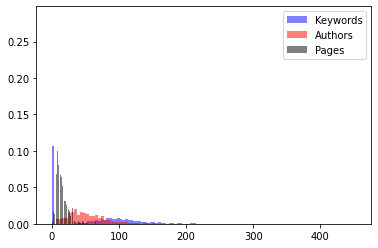

In [85]:
def getPagesCount(pagesCol =  ['End Page', 'Start Page']):
    baseStats = df[pagesCol].copy()
    # baseStats.dropna(inplace=True)
    # baseStats.replace('+', regex=True, inplace=True)

    sum = []
    count = 0
    baseStats.head()
    for i in baseStats.index:
        if type(baseStats.at[i, 'End Page']) == int and type(baseStats.at[i, 'Start Page']) == int:
            sum.append((baseStats.at[i, 'End Page'] - baseStats.at[i, 'Start Page']))
            count += 1
        else:
            sum.append(0)
    return sum


distributionDf = pd.DataFrame()
distributionDf['keyword_count'] = df['Author Keywords'].str.len()
distributionDf['keyword_count'].replace(np.nan, 0, inplace=True)

distributionDf['author_count'] = df['Author Full Names'].str.len()
distributionDf['author_count'].replace(np.nan, 0, inplace=True)
distributionDf['page_count'] = getPagesCount()

# plot everything in distributionDf
fig, ax = plt.subplots()
ax.hist(distributionDf['keyword_count'], bins=100, density=True, label='Keywords', ls='dashed', lw=3, fc=(0, 0, 1, 0.5))
ax.hist(distributionDf['author_count'], bins=100, density=True, label='Authors', ls='dotted', lw=3, fc=(1, 0, 0, 0.5))
ax.hist(distributionDf['page_count'], bins=100, density=True, label='Pages', lw=3, fc=(0, 0, 0, 0.5))
ax.legend()


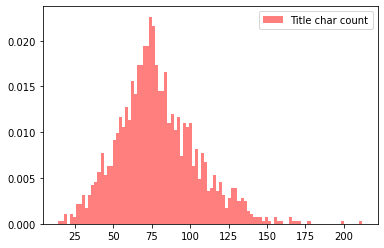

In [93]:
distributionDf['abstr_len'] = df['Abstract'].str.len()
distributionDf['title_len'] = df['Article Title'].str.len()
fig, ax = plt.subplots()
ax.hist(distributionDf['abstr_len'], bins=100, density=True, label='Abstract char count', ls='dashed', lw=3, fc=(0, 0, 1, 0.5))
# ax.hist(distributionDf['title_len'], bins=100, density=True, label='Title char count', ls='dotted', lw=3, fc=(1, 0, 0, 0.5))
ax.legend()


In [87]:
# create graph with publications by Year
def plotPublicationsByYear(df):
    countsDf = df.groupby(['Publication Year'])['Publication Year'].agg("count").sort_index()
    countsDf.to_json('./publicationsByYear.json')
    plt.bar(countsDf.index.astype(int), countsDf.values.astype(int))
    plt.title('Number of Publications per Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Number of Publications')
    plt.show()

def plotTimesCitedMean(df):
    countsDf = df.groupby(['Publication Year'])['Times Cited, WoS Core'].agg('mean').sort_index()
    countsDf.to_json('./timesCitedMean.json')
    plt.bar(countsDf.index.astype(int), countsDf.values.astype(int))
    plt.title('Average Number of Citations per Publication Year')
    plt.xlabel('Publication Year')
    plt.ylabel('Average Number of Citations')
    plt.show()


data = {
    "year": df.groupby(['Publication Year'])['Publication Year'].agg("count").sort_index().index.astype(int),
    "pubCount": df.groupby(['Publication Year'])['Publication Year'].agg("count").sort_index().values.astype(int),
    "totalCite": df.groupby(['Publication Year'])['Times Cited, WoS Core'].agg('count').sort_index().values.astype(int),
    "meanCite": df.groupby(['Publication Year'])['Times Cited, WoS Core'].agg('mean').sort_index().values.astype(int),
}

countsDf = pd.DataFrame(data=data)
print(countsDf.head())
countsDf.to_csv('./timesCitedMean.csv')

   year  pubCount  totalCite  meanCite
0  1999         5          2        11
1  2000        10          9        17
2  2001        13         10        13
3  2002        18         15        46
4  2003        19         17        10


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     29.15
Date:                Mon, 09 May 2022   Prob (F-statistic):           2.02e-05
Time:                        14:05:56   Log-Likelihood:                -118.68
No. Observations:                  24   AIC:                             241.4
Df Residuals:                      22   BIC:                             243.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.131e+04   2105.047     -5.371      0.0

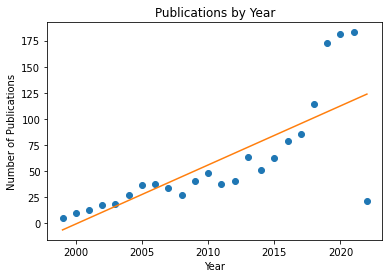

<Figure size 1152x360 with 0 Axes>

In [88]:
from itertools import groupby
import statsmodels.api as sm
allData = df['Publication Year'].dropna(axis=0, how='any').astype(int).sort_values().value_counts(sort=False)
x = allData.index.values.astype(int)
y = allData.values
# create multi linear regression
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
# plot regression
plt.plot(x, y, 'o', x, results.predict(X), '-')
plt.title('Publications by Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.figure(figsize=(16,5))
plt.show()

